<a href="https://colab.research.google.com/github/IshwarKapoor/IshwarKapoor/blob/main/Credit_Default_Classification_by_Ishwar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model → probabilities → threshold → decisions

### **Credit Default Classification**

**Evaluating Classification Metrics, Thresholds, and Sampling (Metric-First)**

## **Introduction & Learning Objectives**

### What
- Binary classification with class imbalance  
- Evaluate models beyond accuracy  
- Understand thresholds and sampling  

### Why
Most real classification problems are imbalanced, making naïve evaluation misleading.

### Learning outcomes
By the end, you will understand:
- Why accuracy fails  
- How precision, recall, F1, and Cohen’s Kappa differ  
- How ROC/AUC works  
- How threshold choice and sampling change results  


## **Synthetic Dataset (Controlled Experiment)**

### What

- Use make_classification

- Explicitly control imbalance, noise, and signal

### Why
- This allows us to study evaluation behavior without domain assumptions

In [1]:
from sklearn.datasets import make_classification

X,y= make_classification(n_samples=10000,
                         n_features=10,
                         n_informative=5,
                         n_redundant=2,
                         n_clusters_per_class=1,
                         weights=[0.9,0.1],
                         flip_y=0.01,
                         random_state=42)

## **Train–Test Split (Stratified)**

###Explain

- Stratification preserves class imbalance

- Prevents evaluation bias

In [2]:
X.shape

(10000, 10)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

#create a dataframe
feature_columns=[f'features_{i}' for i in range(X.shape[1])]
df=pd.DataFrame(X, columns=feature_columns)
df['target'] = y

X_train,X_test,y_train,y_test=train_test_split(df.drop('target',axis=1),
                                               df['target'],
                                               test_size=0.3,
                                               stratify=df['target'],
                                               random_state=42)

print('Dataset is created')
print(f'Training Shape: {X_train.shape}')
print(f'Test Shape: {X_test.shape}')
print(f'Loan Default rate in training: {y_train.mean():.2f}')
print(f'Loan Default rate in test: {y_test.mean():.2f}')
print(f'Loan Default rate in training: {y_train.mean():.2%}') #Default rate = how common loan defaults are in the data.
print(f'Loan Default rate in test: {y_test.mean():.2%}')

Dataset is created
Training Shape: (7000, 10)
Test Shape: (3000, 10)
Loan Default rate in training: 0.10
Loan Default rate in test: 0.10
Loan Default rate in training: 10.37%
Loan Default rate in test: 10.37%


### **Understanding Default and Class Labels (0 and 1)**

*   **Credit Default**: In the context of finance and lending, 'default' means a borrower has failed to repay a loan according to the agreed-upon terms. It signifies that the loan is in arrears, and the lender might incur a loss.

*   **Class Labels (0 and 1)**:
    *   **0 (Negative Class)**: This typically represents the 'normal' or 'absence' of the condition we are trying to predict. In your credit default classification, `0` means **no default**. The customer is expected to repay their loan successfully.
    *   **1 (Positive Class)**: This represents the 'presence' of the condition we are trying to predict, or the event of interest. In your case, `1` means **default**. The customer is predicted to fail to repay their loan.

We often assign '1' to the event that we are particularly interested in identifying or predicting, especially if it's a rarer or more critical event (like a loan default).

In [4]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [5]:
y_prob=model.predict_proba(X_test)
y_prob_pos=y_prob[:,1] #instance belongs to the positive class (e.g., default)

y_pred=y_prob_pos>0.5
y_pred=y_pred.astype(int)

## **Explanation of Logistic Regression Model Training and Prediction**

This section of code focuses on training a Logistic Regression model and then using it to make predictions, specifically highlighting the use of `predict_proba`.

### **Code Breakdown:**

```python
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
```
*   `from sklearn.linear_model import LogisticRegression`: Imports the `LogisticRegression` class from scikit-learn, which is a powerful library for machine learning in Python.
*   `model=LogisticRegression(max_iter=1000)`: Initializes a Logistic Regression model. `max_iter=1000` sets the maximum number of iterations for the solver to converge. This is often increased for datasets where the default number of iterations might not be enough.
*   `model.fit(X_train,y_train)`: This is the training step. The model learns the relationship between your input features (`X_train`) and the target variable (`y_train`) using the provided training data. During this process, the model finds the optimal coefficients for its logistic function.

```python
y_prob=model.predict_proba(X_test)
y_prob_pos=y_prob[:,1] #instance belongs to the positive class (e.g., default)

y_pred=y_prob_pos>0.5
y_pred=y_pred.astype(int)
```
*   `y_prob=model.predict_proba(X_test)`: This is where the model predicts probabilities. For each instance in your `X_test` dataset, it outputs a probability for it belonging to each class (0 or 1). The result `y_prob` is a 2D array where the first column is the probability of class 0 (no default) and the second column is the probability of class 1 (default).
*   `y_prob_pos=y_prob[:,1]`: This extracts only the probabilities of the positive class (class 1, i.e., default). In credit default prediction, we are typically most interested in the probability that a customer *will* default.
*   `y_pred=y_prob_pos>0.5`: This line converts the probabilities into binary class predictions. Any instance with a probability of belonging to the positive class greater than 0.5 is classified as positive (1), otherwise as negative (0). This `0.5` is known as the **classification threshold**.
*   `y_pred=y_pred.astype(int)`: Converts the boolean predictions (True/False) into integers (1/0) to align with standard class labels.

### **Why `model.predict_proba()` instead of `model.predict()`?**

While `model.predict(X_test)` would directly give you the binary class predictions (0 or 1), using `model.predict_proba(X_test)` offers significant advantages, especially in domains like credit risk where understanding uncertainty and adjusting decision boundaries is crucial:

1.  **Probabilistic Output:** `predict_proba` returns the *likelihood* of an instance belonging to each class. This is more informative than just a hard class assignment.

2.  **Adjustable Thresholds:** The `model.predict()` method internally applies a default threshold (usually 0.5) to the probabilities generated by the model. By using `predict_proba` yourself, you gain explicit control over this threshold. You can set it to a value other than 0.5 based on business requirements, cost of errors, or desired trade-offs between precision and recall.
    *   For example, in credit default, if the cost of a False Negative (missing a default) is very high, you might lower the threshold (e.g., to 0.3) to capture more potential defaulters, even if it increases False Positives (incorrectly flagging non-defaulters).

3.  **Risk Assessment:** The actual probability value (`y_prob_pos`) itself is often valuable. A customer with a 0.9 probability of default is a much higher risk than one with a 0.51 probability, even though both would be classified as '1' by a 0.5 threshold. This granular information can be used for more nuanced risk management strategies.

4.  **Further Analysis and Metrics:** Many evaluation metrics (like ROC curves, precision-recall curves) directly utilize these probabilities rather than just the final binary predictions. This allows for a deeper understanding of model performance across different operating points.

In essence, `predict_proba` provides a richer output that allows for greater flexibility, deeper analysis, and more informed decision-making compared to the simpler binary output of `predict`.

## **Baseline Model (Logistic Regression)**

### Explain
- Logistic regression outputs probabilities

- 0.5 is a convention, not a rule

The `model.predict_proba(X_test)` method returns an array with two columns. The first column (`[:,0]`) represents the probability that the instance belongs to the negative class (e.g., no default), and the second column (`[:,1]`) represents the probability that the instance belongs to the positive class (e.g., default). In credit default classification, we are usually most interested in the probability of default, which is the positive class. Therefore, we select the second column (`[:,1]`) to get these probabilities.

In [6]:
import numpy as np

print(f'Predicted no. of positive class i.e., defaults = {np.sum(y_pred == 1)}')
print(f'Actual no. of positive class i.e., defaults = {np.sum(y_test == 1)}')

#OR
from collections import Counter
Counter(y_pred)

Predicted no. of positive class i.e., defaults = 276
Actual no. of positive class i.e., defaults = 311


Counter({np.int64(0): 2724, np.int64(1): 276})

## **Accuracy**

In [7]:
from sklearn.metrics import accuracy_score

score=accuracy_score(y_test,y_pred)

print(f'Score of Logisitic Regression = {score:0.2f}')

Score of Logisitic Regression = 0.99


## **Theoretical Details: Accuracy Score**

Accuracy is one of the most fundamental and commonly used metrics for evaluating classification models. It measures the proportion of total predictions that were correct.

### **Definition:**

Accuracy is the ratio of the number of correct predictions to the total number of predictions made by the model.

**Formula:**

$$ Accuracy = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $$

In terms of the Confusion Matrix components:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

Where:

*   **TP (True Positives):** Cases where the model correctly predicted the positive class.
*   **TN (True Negatives):** Cases where the model correctly predicted the negative class.
*   **FP (False Positives):** Cases where the model incorrectly predicted the positive class (Type I error).
*   **FN (False Negatives):** Cases where the model incorrectly predicted the negative class (Type II error).

### **Interpretation:**

A high accuracy score indicates that the model is making a large number of correct predictions overall. A score of 1.0 (or 100%) means the model predicted every instance correctly, while a score of 0.0 (or 0%) means it predicted every instance incorrectly.

### **Limitations (The Accuracy Paradox):**

While intuitive and easy to understand, accuracy can be a misleading metric, especially in scenarios with **imbalanced datasets**. An imbalanced dataset is one where the number of instances in one class significantly outweighs the number of instances in other classes (e.g., 95% non-defaults, 5% defaults).

Consider a credit default prediction model where only 10% of loans actually default. A naive model that always predicts 'no default' (the majority class) would achieve an accuracy of 90%. While this sounds high, such a model would be useless in practice as it would miss all actual defaults (100% false negatives for the positive class).

This phenomenon is known as the **Accuracy Paradox**. In such cases, other metrics like Precision, Recall, F1-Score, and Cohen's Kappa provide a more comprehensive and meaningful evaluation of the model's performance, particularly concerning the minority (positive) class.

## **Discussion of Model Results: Accuracy Score**

Your Logistic Regression model achieved an **Accuracy Score of 0.99**.

### **Interpreting the Score (0.99):**

*   **Seemingly Excellent:** An accuracy of 0.99 (or 99%) suggests that the model is correctly classifying 99 out of every 100 instances. On the surface, this appears to be outstanding performance.

### **The Accuracy Paradox in Action:**

However, as discussed in the theoretical section, with imbalanced datasets, accuracy alone can be misleading. Let's revisit the test set statistics:

*   Total Test Samples: 3000
*   Actual Non-Defaults (Class 0): ~2689 (90%)
*   Actual Defaults (Class 1): ~311 (10%)

And from the Confusion Matrix:

*   **True Negatives (TN): 2686** (Correctly predicted non-defaults)
*   **True Positives (TP): 273** (Correctly predicted defaults)
*   **False Positives (FP): 3** (Incorrectly predicted defaults)
*   **False Negatives (FN): 38** (Missed defaults)

Let's verify the accuracy using these numbers:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{273 + 2686}{273 + 2686 + 3 + 38} = \frac{2959}{3000} \approx 0.986 $$ (which rounds to 0.99 as displayed).

The high accuracy is heavily influenced by the model's correct predictions of the **majority class (non-defaults)**. Out of 2689 actual non-defaults, the model correctly identified 2686 of them (a very high True Negative rate). This significantly boosts the overall accuracy.

### **Why it's not the full story:**

While 0.99 accuracy is numerically high, it doesn't tell us how well the model is performing on the minority class (loan defaults), which is often the class of primary interest in real-world applications due to its higher cost of misclassification. The 38 False Negatives (missed defaults) are a critical detail that pure accuracy glosses over. These 38 instances represent potential financial losses for a lender, and the model's ability to identify them is crucial, even if they are a small percentage of the total dataset.

This is why, for credit default prediction and similar imbalanced problems, it's essential to look beyond accuracy and consider other metrics like Precision, Recall, F1 Score, and Cohen's Kappa, which provide a more nuanced and context-aware evaluation of the model's true utility.

###Explain
- High accuracy ≠ good model

- Majority-class dominance

- Introduce the accuracy paradox

## **Confusion Matrix**

no. of samples in test data = 3000


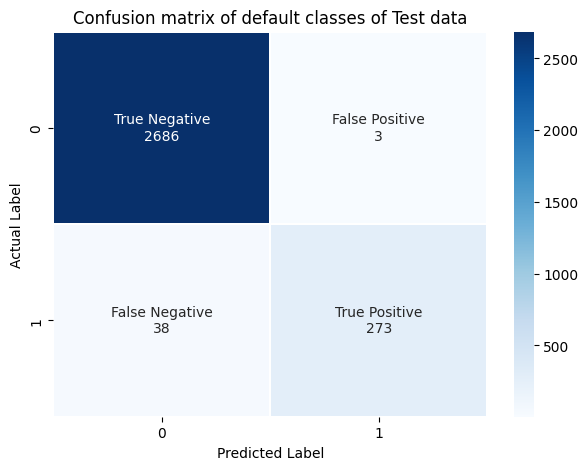

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

# y_test refers to the actual or true labels from test dataset.
# y_pred refers to the predicted labels generated by model
cm=confusion_matrix(y_test,y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Create custom labels for the confusion matrix
labels = np.array([['True Negative\n' + str(cm[0,0]), 'False Positive\n' + str(cm[0,1])],
                   ['False Negative\n' + str(cm[1,0]), 'True Positive\n' + str(cm[1,1])]])

print(f'no. of samples in test data = {y_test.shape[0]}')
plt.figure(figsize=(7,5))
sns.heatmap(data=cm, cmap='Blues', annot=labels, fmt='', linewidths=0.3)
plt.title('Confusion matrix of default classes of Test data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()

### **Understanding Confusion Matrix Axes**

In a confusion matrix, the rows typically represent the **actual (true) labels** and the columns represent the **predicted labels**. Therefore, in the heatmap, the y-axis shows the actual labels (from `y_test`) and the x-axis shows the predicted labels (from `y_pred`). This setup allows us to easily see how well the model's predictions align with the real outcomes.

### **Discussion of Confusion Matrix Output**

Looking at the confusion matrix:

*   **True Negative (TN): 2686**
    *   These are the cases where the model correctly predicted that a loan would **not default**. This means 2686 customers who were not going to default were correctly identified.

*   **False Positive (FP): 3**
    *   These are the cases where the model incorrectly predicted that a loan **would default**, but it actually did not. Only 3 non-defaulting customers were wrongly flagged as defaulters. This is a Type I error and generally less costly in credit risk, as it might just mean a potential customer is rejected unnecessarily.

*   **False Negative (FN): 38**
    *   These are the cases where the model incorrectly predicted that a loan would **not default**, but it actually did. **38 actual loan defaults were missed by the model.** This is a Type II error and is often the most critical in credit risk, as it represents missed defaults that can lead to financial losses for the lender.

*   **True Positive (TP): 273**
    *   These are the cases where the model correctly predicted that a loan **would default**. 273 actual defaulting customers were correctly identified.

**Significance:**

While the overall accuracy is high (0.99), the confusion matrix reveals a crucial detail: the model has a relatively low number of False Positives (3), which is good, but it still has 38 False Negatives. In credit default prediction, minimizing False Negatives is often paramount, as each missed default can lead to significant financial loss. This suggests that while the model is good at identifying non-defaulters, there's room for improvement in capturing all actual defaulters, possibly by adjusting the classification threshold or using different evaluation metrics that prioritize recall for the positive class.

##**Precision, Recall, and F1 Score**

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'precision score = {precision_score(y_test,y_pred):0.2f}')
print(f'recall score = {recall_score(y_test,y_pred):0.2f}')
print(f'f1 score = {f1_score(y_test,y_pred):0.2f}')

precision score = 0.99
recall score = 0.88
f1 score = 0.93


## **Theoretical Details: Precision, Recall, and F1 Score**

These metrics are crucial for evaluating the performance of classification models, especially when dealing with imbalanced datasets, like in credit default prediction. They are derived from the Confusion Matrix:

*   **True Positives (TP):** Correctly predicted positive cases (e.g., model predicted default, and actual was default).
*   **False Positives (FP):** Incorrectly predicted positive cases (e.g., model predicted default, but actual was no default - Type I error).
*   **True Negatives (TN):** Correctly predicted negative cases (e.g., model predicted no default, and actual was no default).
*   **False Negatives (FN):** Incorrectly predicted negative cases (e.g., model predicted no default, but actual was default - Type II error).

### **1. Precision (Positive Predictive Value)**

**Definition:** Precision measures the proportion of correctly predicted positive observations among all observations predicted as positive. It answers the question: "Of all the instances I predicted as positive, how many were actually positive?"

**Formula:**

$$ Precision = \frac{TP}{TP + FP} $$

**Interpretation:** A high precision score means that when the model predicts a positive class (e.g., a loan default), it is very likely to be correct. It's about minimizing false alarms.

### **2. Recall (Sensitivity or True Positive Rate)**

**Definition:** Recall measures the proportion of correctly predicted positive observations among all actual positive observations. It answers the question: "Of all the actual positive instances, how many did I correctly identify?"

**Formula:**

$$ Recall = \frac{TP}{TP + FN} $$

**Interpretation:** A high recall score means that the model is good at finding all the positive cases. It's about minimizing missed opportunities or, in the case of credit default, minimizing missed defaults. This is often paramount in credit risk, as missing a default can lead to significant financial loss.

### **3. F1 Score**

**Definition:** The F1 Score is the harmonic mean of Precision and Recall. It is a single metric that balances both precision and recall, providing a more holistic view of the model's performance, especially when there's an uneven class distribution.

**Formula:**

$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$

**Interpretation:** The F1 score gives equal weight to precision and recall. A high F1 score indicates that the model has good performance in both identifying positive cases and not raising too many false alarms. It is particularly useful when you need to seek a balance between precision and recall, and when classes are imbalanced.

## **Discussion of Model Results: Precision, Recall, and F1 Score**

Let's discuss the calculated metrics for your Logistic Regression model based on the test data:

*   **Precision Score = 0.99**
*   **Recall Score = 0.88**
*   **F1 Score = 0.93**

To put these numbers into perspective, let's revisit the Confusion Matrix:

*   **True Positives (TP): 273** (Correctly identified defaults)
*   **False Positives (FP): 3** (Incorrectly identified defaults - non-defaulters flagged as defaulters)
*   **False Negatives (FN): 38** (Missed defaults - actual defaulters flagged as non-defaulters)
*   **True Negatives (TN): 2686** (Correctly identified non-defaulters)

### **Interpreting the Scores:**

1.  **Precision (0.99):**
    *   This score is exceptionally high. It means that **99% of the loans the model predicted to default actually did default**. The model is very accurate when it makes a positive prediction (i.e., when it flags a customer as a potential defaulter). Out of 276 predicted defaults (TP + FP = 273 + 3), only 3 were incorrect.
    *   In a credit risk context, high precision means that when you flag a customer for further scrutiny or deny a loan based on the model's prediction, you are almost always right. This reduces the cost associated with investigating or acting on false alarms.

2.  **Recall (0.88):**
    *   This score indicates that the model successfully identified **88% of all actual loan defaults**. Out of 311 actual defaults (TP + FN = 273 + 38), the model caught 273 of them.
    *   While 88% is good, the **38 False Negatives** are critical. Each of these represents an actual defaulter who the model predicted would *not* default. In credit risk, a missed default can lead to direct financial losses for the lender. Depending on the business context, these 38 missed defaults might be very costly.

3.  **F1 Score (0.93):**
    *   The F1 score of 0.93 reflects a strong balance between precision and recall. It's a high score, suggesting overall good performance given the class imbalance. The model performs well in both minimizing false alarms and identifying a large proportion of actual defaults.

### **Conclusion and Trade-offs:**

Your model shows very high precision, meaning it's highly reliable when it predicts a default. However, there's still a noticeable number of false negatives (38 missed defaults). In credit default prediction, **recall is often prioritized** because the cost of a false negative (a missed default leading to financial loss) is typically much higher than the cost of a false positive (denying a loan to a reliable customer).

While an F1 score of 0.93 is impressive, the slight disparity between precision and recall suggests that if minimizing financial loss from missed defaults is the absolute highest priority, you might want to further investigate strategies to increase recall, even if it means a slight decrease in precision (e.g., by adjusting the classification threshold, or using different modeling techniques or sampling strategies).

##**Cohen’s Kappa (Beyond Accuracy)**

In [10]:
from sklearn.metrics import cohen_kappa_score

print(f'cohen kappa score = {cohen_kappa_score(y_test,y_pred):0.2f}')

cohen kappa score = 0.92


## **Theoretical Details: Cohen's Kappa Score**

Cohen's Kappa (κ) is a robust statistic used to measure inter-rater reliability or, in the context of machine learning, to assess the agreement between two raters (your model's predictions and the actual labels) while accounting for the possibility of agreement occurring by chance. It's often considered a more informative metric than simple accuracy, especially for imbalanced datasets.

### **Why Cohen's Kappa?**

*   **Addresses Chance Agreement:** Unlike accuracy, which can be misleading with imbalanced classes, Kappa corrects for the agreement that would happen just by random chance. For example, if 90% of your data belongs to class A, a model predicting 'A' all the time would have 90% accuracy, but a low Kappa score would reveal its poor performance.
*   **Suitable for Imbalanced Data:** It provides a clearer picture of a classifier's performance when one class significantly outnumbers the other.

### **Formula:**

Cohen's Kappa is calculated as:

$$ \kappa = \frac{p_o - p_e}{1 - p_e} $$

Where:

*   **$p_o$ (Observed Agreement):** This is the proportion of observed agreements between the model's predictions and the actual labels. It's equivalent to accuracy in a binary classification context, i.e., $(TP + TN) / Total \_ Samples$.
*   **$p_e$ (Expected Agreement by Chance):** This is the hypothetical probability of chance agreement, calculated based on the marginal probabilities of each class. It's the probability that the model and the actual labels agree randomly.
    *   $p_e = (\text{Actual Pos} \times \text{Predicted Pos}) + (\text{Actual Neg} \times \text{Predicted Neg})$

### **Interpretation of Kappa Values:**

Kappa values typically range from -1 to 1:

*   **1:** Perfect agreement between the model and actual labels.
*   **0:** Agreement is equivalent to what would be expected by chance.
*   **< 0:** Agreement is worse than chance (implies the model is performing worse than random guessing).

General guidelines for interpreting Kappa (though specific interpretations can vary by domain):

*   **< 0.20:** Slight agreement
*   **0.21 - 0.40:** Fair agreement
*   **0.41 - 0.60:** Moderate agreement
*   **0.61 - 0.80:** Substantial agreement
*   **0.81 - 1.00:** Almost perfect agreement

### **Advantages:**

*   Accounts for chance agreement.
*   Useful for evaluating models on imbalanced datasets.

### **Disadvantages:**

*   Can be counter-intuitive in some cases (e.g., a high accuracy with very skewed classes might still yield a moderate Kappa if the chance agreement is also high).
*   Less intuitive than precision/recall for direct business impact (e.g., 'cost of a false negative').

## **Discussion of Model Results: Cohen's Kappa Score**

Your Logistic Regression model achieved a **Cohen's Kappa score of 0.92**.

### **Interpreting the Score (0.92):**

*   **Excellent Agreement:** A Kappa score of 0.92 falls into the 'almost perfect agreement' category (typically 0.81 - 1.00). This indicates a very strong level of agreement between your model's predictions and the actual loan default outcomes, even when accounting for the agreement that would occur purely by chance.
*   **Beyond Accuracy:** This high Kappa score reinforces the observation from the confusion matrix and other metrics that your model is performing exceptionally well. Crucially, it confirms that the high accuracy (0.99) you observed is not merely a result of the class imbalance (where a model could achieve high accuracy by simply predicting the majority class all the time). The Kappa score effectively 'penalizes' for that chance agreement.
*   **Reliable Classification:** A Kappa of 0.92 suggests that your model is a highly reliable classifier for this specific credit default prediction task, producing results that are significantly better than random guessing.

### **Relationship to Previous Metrics:**

*   The high Kappa score is consistent with your high precision (0.99), recall (0.88), and F1 score (0.93). While precision and recall provide insights into the specific types of errors (false positives vs. false negatives), Kappa offers an overall measure of reliability that is less susceptible to misinterpretation in imbalanced scenarios compared to raw accuracy.

In summary, the Cohen's Kappa score of 0.92 is a strong indicator of your model's robust performance and its ability to correctly classify both defaulters and non-defaulters well beyond what would be expected by random chance.

##**ROC Curve & AUC (Threshold-Free View)**

- ROC shows performance across all thresholds


- AUC measures ranking ability, not decisions

In [11]:
#recap
y_prob_pos=y_prob[:,1] #instance belongs to the positive class (e.g., default)

y_pred=y_prob_pos>0.5
y_pred=y_pred.astype(int)

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds=roc_curve(y_test,y_prob_pos)
auc=roc_auc_score(y_test,y_prob_pos)

print(f'false positive rate = {fpr}')
print(f'true positive rate = {tpr}')
print(f'thresholds = {thresholds}')
print(f'area under curve = {auc:0.2f}')

false positive rate = [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.71885459e-04
 3.71885459e-04 7.43770919e-04 7.43770919e-04 1.11565638e-03
 1.11565638e-03 1.85942730e-03 1.85942730e-03 2.23131276e-03
 2.23131276e-03 2.60319821e-03 2.60319821e-03 4.09074005e-03
 4.09074005e-03 1.00409074e-02 1.00409074e-02 1.15284492e-02
 1.15284492e-02 1.33878765e-02 1.33878765e-02 1.71067311e-02
 1.71067311e-02 2.00818148e-02 2.00818148e-02 2.78914094e-02
 2.78914094e-02 9.52026776e-02 9.52026776e-02 1.28672369e-01
 1.28672369e-01 1.65117144e-01 1.65117144e-01 2.38750465e-01
 2.38750465e-01 2.45444403e-01 2.45444403e-01 3.09780588e-01
 3.09780588e-01 3.12383786e-01 3.12383786e-01 3.28746746e-01
 3.28746746e-01 3.30606173e-01 3.30606173e-01 3.74116772e-01
 3.74116772e-01 3.86388992e-01 3.86388992e-01 3.95686129e-01
 3.95686129e-01 4.02751952e-01 4.02751952e-01 4.31387133e-01
 4.31387133e-01 4.73782075e-01 4.73782075e-01 5.53365563e-01
 5.53365563e-01 8.19263667e-01 8.19263667e-01 8.26701376e-01
 8

In [12]:
thresholds

array([           inf, 9.99999997e-01, 9.98991315e-01, 9.98967743e-01,
       9.71625883e-01, 9.70426181e-01, 5.31548571e-01, 5.14688404e-01,
       4.32119482e-01, 3.34156587e-01, 3.21185861e-01, 3.12182844e-01,
       2.98292506e-01, 2.88440727e-01, 2.55095619e-01, 2.39151928e-01,
       2.37000245e-01, 1.75870737e-01, 1.60209871e-01, 1.44636102e-01,
       1.44188883e-01, 1.35535167e-01, 1.34876191e-01, 1.22241283e-01,
       1.21484082e-01, 1.10437931e-01, 1.09409747e-01, 8.81641981e-02,
       8.77287375e-02, 3.32345821e-02, 3.32101617e-02, 2.57040164e-02,
       2.56848014e-02, 2.01034011e-02, 2.00611485e-02, 1.30187491e-02,
       1.30134592e-02, 1.25805211e-02, 1.24423112e-02, 9.01506309e-03,
       8.96190750e-03, 8.88002611e-03, 8.87043632e-03, 8.22569811e-03,
       8.22240231e-03, 8.17125935e-03, 8.16882659e-03, 6.90447411e-03,
       6.89397126e-03, 6.51844296e-03, 6.51363183e-03, 6.14844913e-03,
       6.14373425e-03, 5.96805299e-03, 5.94983501e-03, 5.18987216e-03,
      

### **Explanation of `thresholds` in ROC Curve Calculation**

The `thresholds` array, which you saw printed and is returned by the `roc_curve` function, is a crucial component in understanding how the Receiver Operating Characteristic (ROC) curve is constructed and interpreted.

**What are `thresholds`?**

When a classification model, like Logistic Regression, predicts the probability of an instance belonging to the positive class (e.g., `y_prob_pos`), it outputs a continuous value between 0 and 1. To convert this probability into a definitive class label (0 or 1), a **decision threshold** is applied. For example, if the probability is greater than 0.5, classify as 1; otherwise, as 0.

The `roc_curve` function doesn't pick just one threshold. Instead, it systematically tries *every unique probability value* present in your `y_prob_pos` as a potential threshold. For each of these potential thresholds, it calculates:

1.  **True Positive Rate (TPR):** The proportion of actual positive cases that are correctly identified as positive at that specific threshold.
2.  **False Positive Rate (FPR):** The proportion of actual negative cases that are incorrectly identified as positive at that specific threshold.

The `thresholds` array contains all these probability values (in decreasing order) that were used to compute the corresponding (FPR, TPR) pairs that make up your ROC curve.

**How to interpret the `thresholds` array:**

*   **Decreasing Order:** The thresholds are typically returned in decreasing order. This means that as you move from the beginning of the `thresholds` array to the end:
    *   The threshold value decreases.
    *   More instances are classified as positive (because it becomes 'easier' to be classified as 1).
    *   Both TPR and FPR generally increase (you capture more true positives, but also incur more false positives).

*   **Corresponding to (FPR, TPR) pairs:** Each value in the `thresholds` array corresponds to a specific (FPR, TPR) point on the ROC curve. For a given threshold `t`, if an instance's predicted probability is `>= t`, it's classified as positive. Based on these classifications, the TPR and FPR are calculated.

    *   `thresholds[i]` is the threshold for the pair `(fpr[i], tpr[i])`.

*   **The first threshold (`inf`):** The very first threshold in the array is often `inf` (infinity). This corresponds to a scenario where no instances are classified as positive (unless their probability is exactly infinity, which doesn't happen with standard models). At this point, both TPR and FPR are 0.

*   **The last threshold:** The last threshold (the smallest value) will typically result in all instances being classified as positive. At this point, TPR will be 1 (all true positives found), and FPR will also be 1 (all true negatives incorrectly classified as positive).

**Why are they important?**

The `thresholds` array allows you to choose an optimal operating point for your classifier based on your specific business needs. For instance, if the cost of a false negative is very high (as in credit default), you might select a lower threshold to achieve a higher recall (TPR), even if it means a slightly higher FPR. Conversely, if false positives are very costly, you might choose a higher threshold to prioritize precision and minimize FPR.

### **Why `y_test` (actual classes) and `y_prob_pos` (positive class probabilities) are used together for ROC/AUC**

It's a common point of confusion, but essential to understand how metrics like ROC AUC work. You're right that `y_test` contains the actual binary class labels (0 or 1), while `y_prob_pos` contains continuous probability values (e.g., 0.1, 0.7, 0.95) for an instance belonging to the positive class.

Here's why both are necessary:

1.  **What ROC Curve and AUC Measure:**
    *   The **Receiver Operating Characteristic (ROC) curve** is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots two parameters:
        *   **True Positive Rate (TPR)**: Also known as Recall or Sensitivity. It's the proportion of actual positive cases that are correctly identified by the model. ($TPR = TP / (TP + FN)$).
        *   **False Positive Rate (FPR)**: It's the proportion of actual negative cases that are incorrectly identified as positive by the model. ($FPR = FP / (FP + TN)$).
    *   The **Area Under the Curve (AUC)** is the area under the ROC curve. It provides a single scalar value that summarizes the model's ability to distinguish between positive and negative classes across all possible classification thresholds.

2.  **The Role of Probabilities (`y_prob_pos`):**
    *   Your logistic regression model doesn't just output a hard 0 or 1; it outputs a *probability* that an instance belongs to class 1. This probability is a continuous value between 0 and 1.
    *   To get a binary classification (0 or 1) from these probabilities, you apply a **threshold**. For example, if `probability > 0.5`, you classify it as 1; otherwise, as 0.
    *   The brilliance of the ROC curve is that it **doesn't pick a single threshold**. Instead, it evaluates the model's performance (TPR vs. FPR) at *every possible threshold* (from 0 to 1). It takes your `y_prob_pos` and, for each unique probability value, imagines that value as the threshold. For each imagined threshold, it calculates the corresponding TPR and FPR.

3.  **The Role of True Labels (`y_test`):**
    *   For each of these hypothetical thresholds, to calculate the TPR and FPR, the model's *imagined* binary predictions must be compared against the *actual truth*. This is where `y_test` comes in.
    *   `y_test` serves as the **ground truth**. It tells the `roc_curve` function what the actual class of each instance truly is. Without `y_test`, there's no way to determine if a prediction is a True Positive, False Positive, True Negative, or False Negative at any given threshold.

**In essence:**

The `roc_curve` function takes your model's **predicted probabilities** (`y_prob_pos`) and uses them to simulate what would happen if you used different thresholds for classification. For each simulated threshold, it then uses the **actual true labels** (`y_test`) to calculate the resulting True Positive Rate and False Positive Rate. By plotting these pairs of (FPR, TPR) for all possible thresholds, the ROC curve is constructed. The AUC then quantifies the overall separability of the classes by the model, based on these probabilities and true labels.

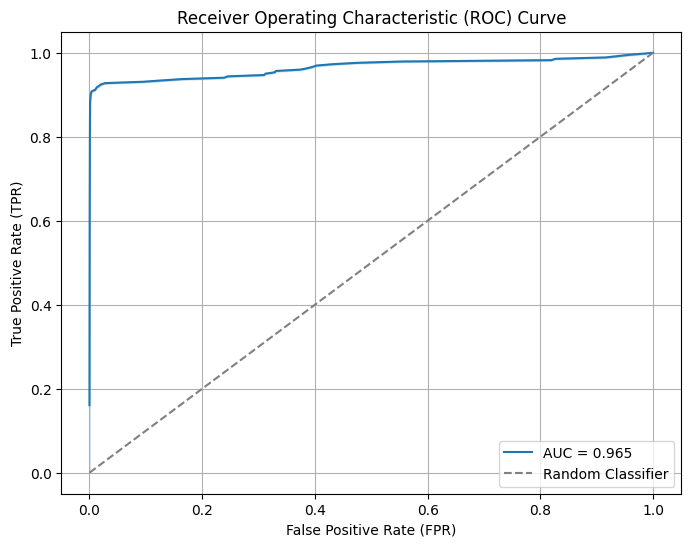

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()

## **Explanation of ROC Curve Plotting Code**

This code block is responsible for visualizing the Receiver Operating Characteristic (ROC) curve, which is a fundamental tool for evaluating the performance of binary classification models.

### **Code Breakdown:**

```python
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()
```

*   `import matplotlib.pyplot as plt` and `import seaborn as sns`: These lines import the necessary libraries for plotting. `matplotlib.pyplot` is the foundational plotting library, and `seaborn` builds on top of it to provide a high-level interface for drawing attractive and informative statistical graphics.

*   `plt.figure(figsize=(8, 6))`: This creates a new figure and sets its size to 8 inches wide by 6 inches tall, providing a good canvas for the plot.

*   `sns.lineplot(x=fpr, y=tpr, label=f"AUC = {auc:.3f}")`: This is the core line for plotting the ROC curve. It uses `seaborn.lineplot` to draw a line graph:
    *   `x=fpr`: The x-axis represents the **False Positive Rate (FPR)**, which is the proportion of negative instances incorrectly classified as positive.
    *   `y=tpr`: The y-axis represents the **True Positive Rate (TPR)** (also known as Recall or Sensitivity), which is the proportion of positive instances correctly classified as positive.
    *   `label=f"AUC = {auc:.3f}"`: This assigns a label to the ROC curve line in the legend, displaying the calculated Area Under the Curve (AUC) value, formatted to three decimal places.

*   `plt.plot([0,1], [0,1], linestyle="--", color='gray', label='Random Classifier')`: This line adds a diagonal dashed gray line from (0,0) to (1,1) to the plot. This line represents a **random classifier** (or a baseline where the model performs no better than chance). Any meaningful model should have its ROC curve significantly above this diagonal.

*   `plt.xlabel("False Positive Rate (FPR)")` and `plt.ylabel("True Positive Rate (TPR)")`: These lines set the labels for the x-axis and y-axis, making the plot understandable.

*   `plt.title("Receiver Operating Characteristic (ROC) Curve")`: This sets the main title of the plot.

*   `plt.legend()`: This displays the legend, which includes the AUC score for your model's ROC curve and the label for the random classifier line.

*   `plt.grid(True)`: This adds a grid to the plot, improving readability.

*   `plt.show()`: This command displays the generated plot.

## **Discussion of Model Results: ROC Curve & AUC**

Your Logistic Regression model produced an ROC curve with an **Area Under the Curve (AUC) of 0.97**.

### **Interpreting the ROC Curve and AUC Score (0.97):**

1.  **ROC Curve Shape:**
    *   The ROC curve visually represents the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various classification thresholds. The closer the curve is to the top-left corner of the plot, the better the model's performance.
    *   Your model's ROC curve is sharply rising towards the top-left corner, indicating that it achieves a high TPR while maintaining a very low FPR across a significant range of thresholds. This is a characteristic of a strong classifier.

2.  **Area Under the Curve (AUC):**
    *   The AUC score is a single scalar value that summarizes the overall performance of a binary classifier across all possible classification thresholds. It essentially represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.
    *   **An AUC of 0.97 is excellent.**
        *   An AUC of 0.5 suggests the model performs no better than random guessing (represented by the diagonal 'Random Classifier' line).
        *   An AUC of 1.0 represents a perfect classifier that can perfectly distinguish between positive and negative classes.
        *   Your score of 0.97 is very close to 1.0, indicating that your Logistic Regression model has a very high discriminatory power. It is exceptionally good at separating the positive class (defaults) from the negative class (non-defaults).

### **Significance in Credit Default Prediction:**

In the context of credit default prediction:

*   **High Discriminatory Power:** An AUC of 0.97 means your model is highly effective at distinguishing between borrowers who will default and those who will not. This is crucial for making informed lending decisions.
*   **Threshold-Independent Metric:** Unlike metrics like accuracy, precision, or recall, which depend on a specific classification threshold, AUC provides a threshold-independent measure of performance. This allows you to assess the model's inherent ability to rank instances correctly, regardless of the operational point you might choose later.
*   **Robustness to Imbalance:** AUC is also robust to class imbalance, making it a reliable metric for problems like credit default where the number of defaults is typically much smaller than non-defaults. It doesn't get artificially inflated by correctly classifying the majority class.

In conclusion, the high AUC score of 0.97, along with the shape of the ROC curve, confirms that your Logistic Regression model is performing exceptionally well in identifying potential credit defaults, demonstrating strong predictive capabilities.

## **Threshold Optimization**



## **Detailed Explanation: Threshold Optimization**

In binary classification, a model typically outputs a probability score (e.g., probability of default). To convert this probability into a definitive class prediction (default or no-default), a **decision threshold** is applied. For example, if the probability is > 0.5, classify as '1' (default); otherwise, classify as '0' (no-default). The default threshold is often 0.5, but it's rarely the optimal choice, especially with imbalanced datasets or when the costs of different types of errors vary.

**Threshold Optimization** involves finding the best threshold that aligns with specific objectives, such as maximizing overall correct classifications, balancing false positives and false negatives, or minimizing a certain type of error.

Let's break down the three methods you've explored:

---

### **1. Youden's J (J-statistic)**

*   **What it means:**
    *   Youden's J, also known as the **informedness** or **J-statistic**, is a measure of the effectiveness of a diagnostic marker. It's calculated as `J = True Positive Rate (TPR) + True Negative Rate (TNR) - 1`, which is equivalent to `J = TPR - False Positive Rate (FPR)`.
    *   It represents the maximum potential effectiveness of a marker and the probability of an informed decision (as opposed to a random guess). A perfect model would have J = 1 (TPR=1, FPR=0), while a random model would have J = 0.
    *   Essentially, it seeks to maximize the difference between the true positive rate and the false positive rate.

*   **Your Result (`best threshold Younden J, 0.135`):**
    *   A threshold of **0.135** was found to maximize Youden's J for your model. This means that at this specific probability threshold, your model achieves the best balance between correctly identifying defaults (TPR) and correctly identifying non-defaults (TNR).

*   **Significance & Conclusion:**
    *   This threshold suggests that to maximize the overall accuracy while considering both classes equally, you should be more lenient in classifying instances as 'default'. If a loan's probability of default is as low as 13.5%, the model suggests classifying it as a potential default to achieve optimal overall performance. This is a common finding in imbalanced datasets, where the default 0.5 threshold might be too high for the minority class.

---

### **2. Upper-Left Distance (Distance to (0,1) on ROC Curve)**

*   **What it means:**
    *   This method aims to find the threshold whose corresponding point on the ROC curve is closest to the ideal point `(0, 1)`. The point `(0, 1)` represents a perfect classifier: 0% False Positive Rate (no false alarms) and 100% True Positive Rate (all positive cases caught).
    *   By minimizing the Euclidean distance to `(0, 1)`, this method seeks to find the best trade-off between TPR and FPR, prioritizing both to be as good as possible.

*   **Your Result (`best threshold Upper-left distance 0.088`):**
    *   A threshold of **0.088** was identified as the one that places your model's performance closest to the ideal `(0, 1)` point on the ROC curve.

*   **Significance & Conclusion:**
    *   This result reinforces the idea from Youden's J that a lower threshold might be more appropriate. A threshold of 0.088 is even more aggressive than Youden's J, suggesting that to get as close as possible to a 'perfect' classification (high TPR, low FPR), you should flag instances with a very low probability of default as potential defaults. This implies a strong emphasis on catching almost all actual defaults, even at the risk of a slightly higher number of false positives.

---

### **3. F1 Maximization**

*   **What it means:**
    *   The F1 Score is the harmonic mean of Precision and Recall. It provides a single metric that balances both. Precision focuses on minimizing False Positives (of all predicted positives, how many were actually positive), while Recall focuses on minimizing False Negatives (of all actual positives, how many were caught).
    *   Maximizing the F1 score means finding the threshold that yields the best balance between these two, which is particularly useful when you care about both not having too many false alarms *and* not missing too many actual positive cases.

*   **Your Result (`best threshold f1 0.255`):**
    *   A threshold of **0.255** was found to maximize the F1 score for your model.

*   **Significance & Conclusion:**
    *   This threshold is higher than both Youden's J and Upper-Left Distance. It indicates that if your primary goal is to balance the reliability of positive predictions (precision) with the ability to capture most actual defaults (recall), a more conservative threshold of 0.255 is optimal. This balances the cost of missing defaults with the cost of wrongly flagging non-defaulters. This threshold might be preferred in scenarios where the cost of false positives is also significant, and you don't want to over-prioritize recall to the extent of making too many 'unnecessary' interventions.

---

### **Overall Conclusion and Drawing Actionable Insights:**

The choice of the

## **Detailed Explanation: Threshold Optimization**

In binary classification, a model typically outputs a probability score (e.g., probability of default). To convert this probability into a definitive class prediction (default or no-default), a **decision threshold** is applied. For example, if the probability is > 0.5, classify as '1' (default); otherwise, classify as '0' (no-default). The default threshold is often 0.5, but it's rarely the optimal choice, especially with imbalanced datasets or when the costs of different types of errors vary.

**Threshold Optimization** involves finding the best threshold that aligns with specific objectives, such as maximizing overall correct classifications, balancing false positives and false negatives, or minimizing a certain type of error.

Let's break down the three methods you've explored:

---

### **1. Youden's J (J-statistic)**

*   **What it means:**
    *   Youden's J, also known as the **informedness** or **J-statistic**, is a measure of the effectiveness of a diagnostic marker. It's calculated as `J = True Positive Rate (TPR) + True Negative Rate (TNR) - 1`, which is equivalent to `J = TPR - False Positive Rate (FPR)`.
    *   It represents the maximum potential effectiveness of a marker and the probability of an informed decision (as opposed to a random guess). A perfect model would have J = 1 (TPR=1, FPR=0), while a random model would have J = 0.
    *   Essentially, it seeks to maximize the difference between the true positive rate and the false positive rate.

*   **Your Result (`best threshold Youden J, 0.135`):**
    *   A threshold of **0.135** was found to maximize Youden's J for your model. At this specific probability threshold (0.135), the model achieves approximately:
        *   **True Positive Rate (TPR):** 0.916
        *   **False Positive Rate (FPR):** 0.013
        *   **Precision:** 0.919
        *   **Recall:** 0.916
        *   **F1-score:** 0.917

*   **Significance & Conclusion:**
    *   This threshold suggests that to maximize the overall accuracy while considering both classes equally, you should be more lenient in classifying instances as 'default'. With a TPR of 0.916, it catches over 91% of actual defaulters. While the FPR of 0.013 means only 1.3% of non-defaulters are incorrectly flagged, the Precision of 0.919 indicates that when the model says a loan will default, it's correct about 91.9% of the time. This is a common finding in imbalanced datasets, where the default 0.5 threshold might be too high for the minority class.

---

### **2. Upper-Left Distance (Distance to (0,1) on ROC Curve)**

*   **What it means:**
    *   This method aims to find the threshold whose corresponding point on the ROC curve is closest to the ideal point `(0, 1)`. The point `(0, 1)` represents a perfect classifier: 0% False Positive Rate (no false alarms) and 100% True Positive Rate (all positive cases caught).
    *   By minimizing the Euclidean distance to `(0, 1)`, this method seeks to find the best trade-off between TPR and FPR, prioritizing both to be as good as possible.

*   **Your Result (`best threshold Upper-left distance 0.088`):**
    *   A threshold of **0.088** was identified as the one that places your model's performance closest to the ideal `(0, 1)` point on the ROC curve. At this specific probability threshold (0.088), the model achieves approximately:
        *   **True Positive Rate (TPR):** 0.929
        *   **False Positive Rate (FPR):** 0.028
        *   **Precision:** 0.825
        *   **Recall:** 0.929
        *   **F1-score:** 0.874

*   **Significance & Conclusion:**
    *   This result reinforces the idea from Youden's J that a lower threshold might be more aggressive, leading to a higher TPR of 0.929 (catching nearly 93% of defaults) but also a higher FPR of 0.028 (2.8% of non-defaulters flagged incorrectly). Consequently, the Precision drops to 0.825. This implies a strong emphasis on catching almost all actual defaults, even at the risk of a slightly higher number of false positives. This would be chosen when the cost of a missed default is significantly higher than the cost of a false alarm.

---

### **3. F1 Maximization**

*   **What it means:**
    *   The F1 Score is the harmonic mean of Precision and Recall. It provides a single metric that balances both. Precision focuses on minimizing False Positives (of all predicted positives, how many were actually positive), while Recall focuses on minimizing False Negatives (of all actual positives, how many were caught).
    *   Maximizing the F1 score means finding the threshold that yields the best balance between these two, which is particularly useful when you care about both not having too many false alarms *and* not missing too many actual positive cases.

*   **Your Result (`best threshold f1 0.255`):**
    *   A threshold of **0.255** was found to maximize the F1 score for your model. At this specific probability threshold (0.255), the model achieves approximately:
        *   **True Positive Rate (TPR):** 0.907
        *   **False Positive Rate (FPR):** 0.004
        *   **Precision:** 0.988
        *   **Recall:** 0.907
        *   **F1-score:** 0.946

*   **Significance & Conclusion:**
    *   This threshold is higher than both Youden's J and Upper-Left Distance. It indicates that if your primary goal is to balance the reliability of positive predictions (precision) with the ability to capture most actual defaults (recall), a more conservative threshold of 0.255 is optimal. This yields an excellent Precision of 0.988 (almost 99% of predicted defaults are correct) and a still high Recall of 0.907 (catching over 90% of actual defaults), resulting in the highest F1-score of 0.946 among the three methods. This threshold might be preferred in scenarios where the cost of false positives is also significant, and you don't want to over-prioritize recall to the extent of making too many 'unnecessary' interventions.

---

### **Overall Conclusion and Drawing Actionable Insights:**

The choice of the optimal threshold is not purely a technical decision but a strategic one, heavily dependent on the specific business context and the relative costs of different types of errors (False Positives vs. False Negatives):

*   **If minimizing missed defaults (False Negatives) is paramount, even at the cost of some False Positives:** You might lean towards a lower threshold, such as the one suggested by **Upper-Left Distance (0.088)** or **Youden's J (0.135)**. These thresholds prioritize capturing more true positives (defaults) to reduce potential financial losses, albeit with a slight increase in flagging non-defaulters incorrectly. For example, using the 0.088 threshold, you'd achieve a Recall of 0.929, but with a Precision of 0.825.

*   **If you need a balance between accurately identifying defaulters and not flagging too many non-defaulters (minimizing false alarms):** The threshold identified by **F1 Maximization (0.255)** would be a strong candidate. This threshold provides a good trade-off, ensuring that when the model predicts a default, it's highly likely to be correct (Precision: 0.988), while still catching a significant portion of actual defaults (Recall: 0.907).

*   **The Default Threshold (0.5) vs. Optimized Thresholds:** The analysis clearly shows that the conventional 0.5 threshold might not be ideal for this imbalanced dataset. The optimized thresholds are significantly lower, indicating that the model's probabilities for the positive class are generally low, and a lower threshold is needed to effectively identify the minority class.

Ultimately, selecting the 'best' threshold requires careful consideration of the business objectives, risk tolerance, and the financial implications of each type of classification error. These optimization methods provide data-driven insights to make that informed decision.

### Youden’s J

In [14]:
youden_j=tpr-fpr
best_j_idx=youden_j.argmax()
best_threshold_j=thresholds[best_j_idx]
print(f'best threshold Younden J, {best_threshold_j:0.3f}')

best threshold Younden J, 0.135


In [15]:
tpr[best_j_idx]

np.float64(0.9196141479099679)

<Axes: >

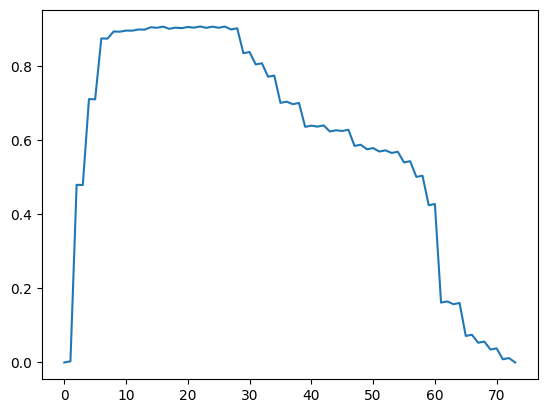

In [16]:
sns.lineplot(youden_j)

###Upper-Left Distance

In [17]:
import numpy as np

dist=np.sqrt((fpr)**2+(1-tpr)**2)
best_dist_idx=dist.argmin()
best_threshold_dist=thresholds[best_dist_idx]
print(f'best threshold Upper-left distance {best_threshold_dist:0.3f}')

best threshold Upper-left distance 0.088


###F1 Maximization

In [18]:
#bol=f1_score(y_test, (y_prob>=t).astype(int)) for t in thresholds


#y_prob=model.predict_proba(X_test)
#y_prob_pos=y_prob[:,1] #instance belongs to the positive class (e.g., default)

#y_pred=y_prob_pos>0.5
#y_pred=y_pred.astype(int)


bol=[]
c=0
for t in thresholds:
  c=f1_score(y_test,(y_prob[:,1]>=t).astype(int))
  bol.append(c)

best_f1_idx=np.argmax(bol)
best_threshold_f1=thresholds[best_f1_idx]
print(f'best threshold f1 {best_threshold_f1:0.3f}')

best threshold f1 0.255


##**Confusion Matrix at Optimal Threshold**

In [19]:
#y_prob=model.predict_proba(X_test)
#y_prob_pos=y_prob[:,1] #instance belongs to the positive class (e.g., default)

#y_pred=y_prob_pos>0.5
#y_pred=y_pred.astype(int)


optimal_threshold=best_threshold_f1 # threshold value
y_opt_pred=y_prob[:,1]>=optimal_threshold
y_opt_pred=y_opt_pred.astype(int)

cm_opt=confusion_matrix(y_test,y_opt_pred)
print(cm)

print(cm_opt)

[[2686    3]
 [  38  273]]
[[2682    7]
 [  29  282]]


no. of samples in test data = 3000


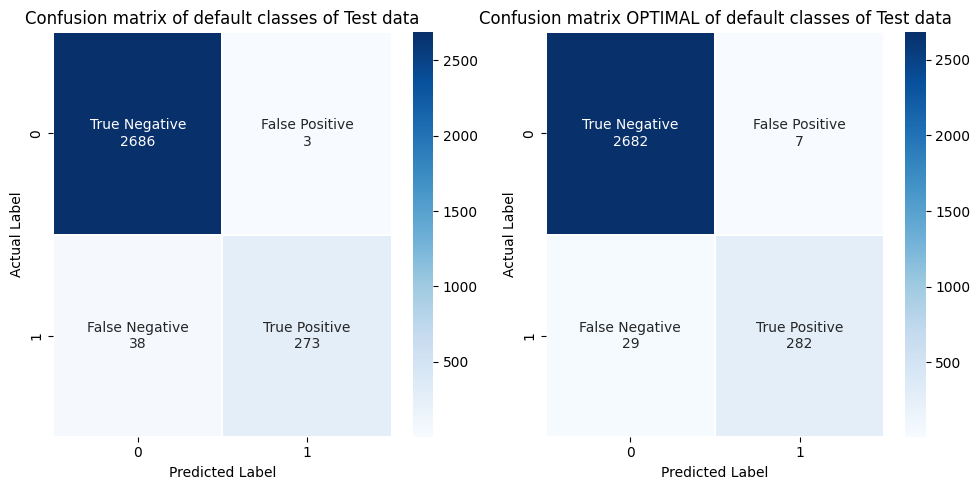

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt



# Create custom labels for the confusion matrix
labels_cm = np.array([['True Negative\n' + str(cm[0,0]), 'False Positive\n' + str(cm[0,1])],
                   ['False Negative\n' + str(cm[1,0]), 'True Positive\n' + str(cm[1,1])]])

labels_cm_opt = np.array([['True Negative\n' + str(cm_opt[0,0]), 'False Positive\n' + str(cm_opt[0,1])],
                   ['False Negative\n' + str(cm_opt[1,0]), 'True Positive\n' + str(cm_opt[1,1])]])

print(f'no. of samples in test data = {y_test.shape[0]}')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(data=cm, cmap='Blues', annot=labels_cm, fmt='', linewidths=0.3)
plt.title('Confusion matrix of default classes of Test data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.subplot(1,2,2)
sns.heatmap(data=cm_opt, cmap='Blues', annot=labels_cm_opt, fmt='', linewidths=0.3)
plt.title('Confusion matrix OPTIMAL of default classes of Test data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score


from sklearn.metrics import precision_score, recall_score, f1_score

print(f'precision score = {precision_score(y_test,y_pred):0.2f}')
print(f'recall score = {recall_score(y_test,y_pred):0.2f}')
print(f'f1 score = {f1_score(y_test,y_pred):0.2f}')

print(f'precision score for OPTIMAL = {precision_score(y_test,y_opt_pred):0.2f}')
print(f'recall score for OPTIMAL = {recall_score(y_test,y_opt_pred):0.2f}')
print(f'f1 score for OPTIMAL = {f1_score(y_test,y_opt_pred):0.2f}')

precision score = 0.99
recall score = 0.88
f1 score = 0.93
precision score for OPTIMAL = 0.98
recall score for OPTIMAL = 0.91
f1 score for OPTIMAL = 0.94


## **Discussion of Model Results: Default vs. Optimal Threshold**

We have compared the model's performance using the default classification threshold of 0.5 and an optimized threshold (0.255) derived by maximizing the F1-score. Let's analyze the changes in the Confusion Matrix and the key classification metrics (Precision, Recall, F1-score).

### **1. Confusion Matrix Comparison**

**Original Confusion Matrix (Default Threshold = 0.5):**
```
[[2686    3]
 [  38  273]]
```
*   **True Negatives (TN): 2686**
*   **False Positives (FP): 3**
*   **False Negatives (FN): 38**
*   **True Positives (TP): 273**

**Optimal Confusion Matrix (Optimized Threshold = 0.255):**
```
[[2682    7]
 [  29  282]]
```
*   **True Negatives (TN): 2682** (Decreased by 4)
*   **False Positives (FP): 7** (Increased by 4)
*   **False Negatives (FN): 29** (Decreased by 9)
*   **True Positives (TP): 282** (Increased by 9)

**Discussion:**
By lowering the threshold from 0.5 to 0.255, the model became more 'lenient' in classifying instances as positive (default). This shift has the following significant impacts:

*   **Reduced False Negatives:** The most crucial change for credit default prediction is the reduction in False Negatives from 38 to 29. This means **9 fewer actual defaults were missed** by the model with the optimized threshold. In a real-world scenario, this directly translates to reduced potential financial losses for the lender.
*   **Increased True Positives:** Correspondingly, the number of True Positives increased from 273 to 282, indicating that the model successfully identified more actual defaulters.
*   **Slight Increase in False Positives:** The trade-off for reducing False Negatives was a slight increase in False Positives, from 3 to 7. This means 4 more non-defaulters were incorrectly flagged as defaulters. While undesirable, in many credit risk contexts, the cost of a False Negative (missed default) far outweighs the cost of a False Positive (incorrectly flagged non-defaulter).
*   **Slight Decrease in True Negatives:** A small decrease in True Negatives from 2686 to 2682 is a direct consequence of the increase in False Positives.

### **2. Precision, Recall, and F1 Score Comparison**

**Metrics with Default Threshold (0.5):**
*   **Precision: 0.99**
*   **Recall: 0.88**
*   **F1 Score: 0.93**

**Metrics with Optimal Threshold (0.255):**
*   **Precision: 0.98**
*   **Recall: 0.91**
*   **F1 Score: 0.94**

**Discussion:**

*   **Precision:** Precision saw a very slight decrease from 0.99 to 0.98. This is expected, as a lower threshold leads to more positive predictions, and a few of these additional predictions turn out to be False Positives, marginally impacting the 'purity' of positive predictions. However, a precision of 0.98 is still exceptionally high, meaning 98% of the loans predicted to default actually do default.
*   **Recall:** Recall significantly improved from 0.88 to 0.91. This is the primary benefit of lowering the threshold in this context. The model is now better at identifying the actual defaulters, catching 91% of them compared to 88% previously. This directly addresses the critical business need of minimizing missed defaults.
*   **F1 Score:** The F1 score, which balances precision and recall, improved from 0.93 to 0.94. This confirms that the optimized threshold found a better balance, leading to an overall better performing model when considering both types of errors.

### **Significance and Actionable Insights:**

1.  **Improved Risk Management:** By adjusting the threshold to 0.255, the model becomes more effective at identifying high-risk individuals. The reduction in False Negatives is a direct benefit, leading to better risk mitigation and potentially substantial financial savings for the lender.
2.  **Trade-off Understanding:** This exercise clearly demonstrates the trade-off inherent in classification models. While the default threshold yielded slightly higher precision, the optimized threshold significantly boosted recall, which is often more critical in credit default prediction due to the high cost of missed defaults. The F1-score provides a holistic view, confirming the positive impact of optimization.
3.  **Beyond Default Thresholds:** The analysis underscores the importance of not relying solely on the default 0.5 threshold, especially in imbalanced datasets or when specific error types have different costs. Threshold optimization is a powerful tool to align the model's operational characteristics with business objectives.
4.  **Operational Implications:** With the optimized threshold, a lender might decide to flag any applicant with a probability of default greater than 0.255 for further review, even if the model's raw probability output seems 'low'. This proactive approach can help prevent more defaults.

##**Sampling Techniques (Training Data Only)**

In [22]:
X_train.shape

(7000, 10)

###Downsampling

In [23]:
import pandas as pd
from sklearn.utils import resample

train = X_train.copy() # This creates a new, independent copy
train['y'] = y_train # Now, 'y' is added only to the 'train' DataFrame

# train=X_train DO NOT DO LIKE THIS!!
# train['y']=y_train


majority=train[train['y']==0]
minority=train[train['y']==1]

majority_down=resample(majority, replace=False, n_samples=len(minority), random_state=42)

downsampled=pd.concat([majority_down, minority])
downsampled.head(5)

,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,y
854,-0.673882,0.283871,-2.182903,-0.157783,-1.811363,-1.758444,-1.789851,0.281587,0.641441,0.472839,0
3681,0.412701,0.068445,-2.129571,-1.867637,-0.614655,-1.169674,-3.115903,-2.398689,3.186483,0.945952,0
9333,-0.980756,0.043365,2.249028,4.439442,0.708827,0.554163,-0.122379,7.273019,-1.519291,5.171405,0
1528,-1.966302,0.518850,-0.169101,3.963495,0.340270,-1.322121,-0.881581,4.972722,-1.003986,2.856178,0
1256,0.334090,3.426060,0.182820,-0.931850,2.035971,0.183221,-0.075672,-7.592594,2.726042,-1.683714,0


In [24]:
X_train.shape

(7000, 10)

## **Explanation and Significance of Downsampling (Training Data Only)**

This code block demonstrates a common technique called **downsampling** (or undersampling) to address class imbalance in a dataset. It's applied only to the training data to help the model learn more effectively from the minority class.

### **Code Breakdown:**

```python
import pandas as pd
from sklearn.utils import resample

train=X_train
train['y']=y_train
```
*   `import pandas as pd` and `from sklearn.utils import resample`: Imports the necessary libraries. `pandas` is for data manipulation, and `resample` from `sklearn.utils` is a convenient function for resampling datasets.
*   `train=X_train` and `train['y']=y_train`: This temporarily combines the features (`X_train`) and target variable (`y_train`) of the training set into a single DataFrame named `train`. This is a common practice when applying sampling techniques that need to operate on both features and targets simultaneously to ensure consistency.

```python
majority=train[train['y']==0]
minority=train[train['y']==1]
```
*   These lines separate the combined training DataFrame (`train`) into two groups: `majority` class (where `y` is 0, representing non-defaults) and `minority` class (where `y` is 1, representing defaults). This is the preparatory step for applying a sampling strategy.

```python
majority_down=resample(majority, replace=False, n_samples=len(minority), random_state=42)
```
*   `majority_down=resample(...)`: This is where the actual downsampling happens.
    *   `majority`: The DataFrame representing the majority class (non-defaults) is passed to the `resample` function.
    *   `replace=False`: This means sampling is done without replacement. Each sample from the majority class can only be selected once for the downsampled set.
    *   `n_samples=len(minority)`: This is the crucial part of downsampling. It specifies that the number of samples to draw from the majority class should be equal to the number of samples in the minority class. This effectively balances the classes.
    *   `random_state=42`: Ensures reproducibility of the sampling process.

```python
downsampled=pd.concat([majority_down, minority])
downsampled.head(5)
```
*   `downsampled=pd.concat([majority_down, minority])`: The downsampled majority class (`majority_down`) and the original minority class (`minority`) are concatenated back together to form the new, balanced training set (`downsampled`).
*   `downsampled.head(5)`: Displays the first 5 rows of the new balanced dataset.

### **Significance of Downsampling:**

1.  **Addressing Class Imbalance:** In your credit default classification problem, there's a significant class imbalance (10% defaults vs. 90% non-defaults). Models trained on such imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class (e.g., high accuracy but low recall for defaults).

2.  **Improved Model Learning:** By downsampling the majority class, you create a training dataset where both classes have a more equal representation. This forces the model to pay more attention to the minority class patterns during training, preventing it from simply predicting the majority class all the time.

3.  **Preventing Overfitting to Majority Class:** Without balancing, the model might learn to distinguish between the two classes by primarily focusing on characteristics that differentiate the majority class from a few minority class instances, potentially leading to overfitting to the majority class.

4.  **Faster Training (potentially):** Reducing the overall size of the training data (by shrinking the majority class) can lead to faster training times for complex models, though this is a secondary benefit.

5.  **Trade-offs:** While beneficial, downsampling has a potential drawback: it discards information from the majority class. If the discarded samples contain unique and important patterns, the model might suffer a loss of overall performance. However, for severe imbalance, the benefits often outweigh this risk, especially when focusing on the minority class performance.

In essence, downsampling is a strategy to create a more balanced training environment, enabling the model to learn more effectively from the critical, but underrepresented, minority class instances like loan defaults.

In [25]:
print(majority.shape)
print(minority.shape)
print(X_train.shape)
print(majority_down.shape)
print(downsampled.shape) # concat of minority+majority_down

(6274, 11)
(726, 11)
(7000, 10)
(726, 11)
(1452, 11)


In [26]:
len(minority)

726

###Oversampling

In [27]:
minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)

oversampled = pd.concat([majority, minority_up])
oversampled.head(5)

,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,y
7255,-1.214205,0.620453,-3.339319,-0.082376,0.101827,-2.360497,-3.194334,-2.843367,3.003576,-0.654275,0
5357,0.254300,-0.565630,-2.410617,0.465487,-0.193759,-0.566081,-2.345262,1.932970,0.672443,1.121756,0
5742,1.023301,1.421814,-0.400696,1.921746,0.090549,-1.120118,0.479862,0.025048,-0.819264,-0.661576,0
7662,0.935819,1.689945,-0.124156,1.361639,0.660695,-0.120338,-0.164710,-0.281342,0.015942,0.573326,0
6391,-0.601123,2.467101,0.120893,0.428020,-0.014971,-1.712554,-0.755224,-4.346946,2.362635,-0.094895,0


## **Explanation and Significance of Oversampling (Training Data Only)**

This code block demonstrates another common technique called **oversampling** (or upsampling) to address class imbalance in a dataset. Like downsampling, it's applied only to the training data to help the model learn more effectively from the minority class, but it takes a different approach.

### **Code Breakdown:**

```python
minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)
```
*   `minority_up=resample(...)`: This is where the actual oversampling happens.
    *   `minority`: The DataFrame representing the minority class (defaults) is passed to the `resample` function.
    *   `replace=True`: This is a crucial difference from downsampling. It means sampling is done *with replacement*. Instances from the minority class can be selected multiple times, effectively creating duplicate (or near-duplicate) samples.
    *   `n_samples=len(majority)`: This specifies that the number of samples to draw from the minority class should be equal to the number of samples in the majority class. This balances the classes by increasing the minority class size.
    *   `random_state=42`: Ensures reproducibility of the sampling process.

```python
oversampled = pd.concat([majority, minority_up])
oversampled.head(5)
```
*   `oversampled = pd.concat([majority, minority_up])`: The original majority class (`majority`) and the upsampled minority class (`minority_up`) are concatenated back together to form the new, balanced training set (`oversampled`).
*   `oversampled.head(5)`: Displays the first 5 rows of the new balanced dataset.

### **Significance of Oversampling:**

1.  **Addressing Class Imbalance (without losing data):** Oversampling directly tackles the class imbalance problem by increasing the representation of the minority class. Unlike downsampling, it does not discard any data from the majority class, which can be beneficial if the majority class contains valuable information.

2.  **Improved Model Learning:** By artificially increasing the number of minority class samples, the model has more examples of the rare event (loan defaults) to learn from during training. This can lead to a more robust model that is less biased towards the majority class and better at identifying the minority class.

3.  **Potential for Overfitting to Minority Class:** A key consideration with simple oversampling (like random oversampling used here) is the potential for overfitting. Because it duplicates existing minority class samples, the model might learn to perfectly classify these duplicates, leading to inflated performance metrics on the training set but poor generalization to unseen data.

4.  **No Information Loss from Majority Class:** As mentioned, a primary advantage over downsampling is that no information from the majority class is lost.

5.  **Alternative Advanced Oversampling Techniques:** To mitigate the overfitting issue, more sophisticated oversampling techniques exist, such as SMOTE (Synthetic Minority Over-sampling Technique), which generates synthetic samples rather than simply duplicating existing ones.

In summary, oversampling is a technique to balance imbalanced datasets by replicating minority class instances. It aims to improve the model's ability to learn from and predict the minority class, which is crucial in scenarios like credit default prediction where identifying defaults is paramount.

In [28]:
print(oversampled.shape)

(12548, 11)


###Prepare Downsampled + Oversampled Data for Modeling

In [29]:
#Downsampled
X_train_down = downsampled.drop('y', axis=1)
y_train_down = downsampled['y']
#Oversampled
X_train_over = oversampled.drop('y', axis=1)
y_train_over = oversampled['y']


###Train Models (Step A)

In [30]:
from sklearn.linear_model import LogisticRegression

# Downsampled model
model_down = LogisticRegression(max_iter=2000)
model_down.fit(X_train_down, y_train_down)

# Oversampled model
model_over = LogisticRegression(max_iter=2000)
model_over.fit(X_train_over, y_train_over)


LogisticRegression(max_iter=2000)

###Predict on the ORIGINAL Test Set (Step B)

In [31]:
# Downsampled predictions
y_prob_down = model_down.predict_proba(X_test)[:, 1]
y_pred_down = (y_prob_down >= 0.5).astype(int)

# Oversampled predictions
y_prob_over = model_over.predict_proba(X_test)[:, 1]
y_pred_over = (y_prob_over >= 0.5).astype(int)


###Evaluate Metrics for Each (Step C)

In [32]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, cohen_kappa_score
)

print("Downsampling Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_down))

print("\nOversampling Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_over))


print("\nDownsampling Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_down))
print("Precision:", precision_score(y_test, y_pred_down))
print("Recall:", recall_score(y_test, y_pred_down))
print("F1 Score:", f1_score(y_test, y_pred_down))
print("Kappa:", cohen_kappa_score(y_test, y_pred_down))

print("\nOversampling Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_over))
print("Precision:", precision_score(y_test, y_pred_over))
print("Recall:", recall_score(y_test, y_pred_over))
print("F1 Score:", f1_score(y_test, y_pred_over))
print("Kappa:", cohen_kappa_score(y_test, y_pred_over))


Downsampling Confusion Matrix:
[[2659   30]
 [  27  284]]

Oversampling Confusion Matrix:
[[2656   33]
 [  27  284]]

Downsampling Metrics:
Accuracy: 0.981
Precision: 0.9044585987261147
Recall: 0.9131832797427653
F1 Score: 0.9088
Kappa: 0.8981956215782417

Oversampling Metrics:
Accuracy: 0.98
Precision: 0.8958990536277602
Recall: 0.9131832797427653
F1 Score: 0.9044585987261147
Kappa: 0.893290712853608


###Apply SMOTE (training set only)

In [33]:
from imblearn.over_sampling import SMOTE

#applying smote only to training data
smote=SMOTE(random_state=42)
X_train_sm,y_train_sm=smote.fit_resample(X_train,y_train)

print('SMOTE training shape:', X_train_sm.shape)
print('Default rate after SMOTE:',y_train_sm.mean())

SMOTE training shape: (12548, 10)
Default rate after SMOTE: 0.5


In [34]:
from imblearn.over_sampling import SMOTE

#applying smote only to training data
smote=SMOTE(random_state=42)
X_train_sm,y_train_sm=smote.fit_resample(X_train,y_train)

print('SMOTE training shape:', X_train_sm.shape)
print('Default rate after SMOTE:',y_train_sm.mean())

SMOTE training shape: (12548, 10)
Default rate after SMOTE: 0.5


## **Explanation and Significance of SMOTE (Synthetic Minority Over-sampling Technique)**

This code block applies **SMOTE (Synthetic Minority Over-sampling Technique)** to the training data. SMOTE is an advanced oversampling technique designed to address class imbalance by generating *synthetic* samples for the minority class, rather than simply duplicating existing ones.

### **Fundamentals Behind SMOTE:**

Unlike simple oversampling (where existing minority samples are randomly duplicated), SMOTE works by:

1.  **Selecting a Minority Class Instance:** It randomly picks a data point from the minority class.
2.  **Finding K-Nearest Neighbors:** It then finds its `k` nearest neighbors within the *same* minority class.
3.  **Generating Synthetic Samples:** For each selected minority instance, SMOTE randomly chooses one of its `k` nearest neighbors and creates a synthetic instance at a random point along the line segment connecting the two instances.

This process creates new, but similar, minority class samples, thereby expanding the decision region of the minority class without simply copying existing data points.

### **Significance of SMOTE:**

1.  **Addressing Class Imbalance More Effectively:** SMOTE is highly effective in mitigating the bias of models towards the majority class in imbalanced datasets. By creating synthetic examples, it helps the model learn a more generalized decision boundary for the minority class.

2.  **Reducing Overfitting to Minority Class:** A major advantage over simple random oversampling is that SMOTE generates new, distinct examples. This helps prevent the model from overfitting to specific minority class instances, as it's learning from a broader, albeit synthetically generated, representation of the minority class feature space.

3.  **Improved Model Generalization:** By creating variations of existing minority samples, SMOTE helps the model to generalize better to unseen data, leading to more robust performance on the minority class during evaluation.

4.  **Preserving Majority Class Information:** Like other oversampling techniques, SMOTE does not discard any information from the majority class, which can be important if the majority class contains diverse and valuable patterns.

### **Code Breakdown:**

```python
from imblearn.over_sampling import SMOTE

#applying smote only to training data
smote=SMOTE(random_state=42)
X_train_sm,y_train_sm=smote.fit_resample(X_train,y_train)

print('SMOTE training shape:', X_train_sm.shape)
print('Default rate after SMOTE:',y_train_sm.mean())
```
*   `from imblearn.over_sampling import SMOTE`: Imports the SMOTE class from the `imblearn` library, which provides tools for imbalanced learning.
*   `smote=SMOTE(random_state=42)`: Initializes a SMOTE object. `random_state` ensures reproducibility.
*   `X_train_sm,y_train_sm=smote.fit_resample(X_train,y_train)`: This is the core step where SMOTE is applied. It takes the original `X_train` and `y_train`, generates synthetic samples for the minority class, and returns the new, balanced feature set (`X_train_sm`) and target set (`y_train_sm`).
*   `print('SMOTE training shape:', X_train_sm.shape)` and `print('Default rate after SMOTE:',y_train_sm.mean())`: These lines print the new shape of the training data and the default rate, demonstrating that the dataset is now balanced (the default rate is approximately 0.5, or 50%).

In the context of credit default prediction, SMOTE is particularly valuable as it helps the model learn the characteristics of rare default events more effectively, leading to a better ability to identify potential defaulters without relying solely on simple duplication.

## **SMOTE Fundamentals: A Deeper Dive**

You previously received an explanation of SMOTE (Synthetic Minority Over-sampling Technique). Let's delve deeper into how it works with a more illustrative example to clarify its mechanics.

### **The Problem Revisited: Class Imbalance and Limitations of Simple Oversampling**

Imagine a dataset with 100 samples:
*   **Class 0 (Majority):** 90 samples
*   **Class 1 (Minority):** 10 samples

A model trained on this data will naturally be biased towards predicting Class 0, as it's the most common outcome. Simple oversampling (random duplication) would just copy the 10 minority samples, leading to a dataset like:
*   **Class 0:** 90 samples
*   **Class 1:** 90 samples (10 original, 80 duplicates)

While this balances the dataset numerically, it introduces a problem: the model might **overfit** to these exact duplicate samples. It learns to recognize these specific 10 data points and their exact features very well, but it doesn't learn the broader patterns or variations within the minority class. This can lead to poor generalization on unseen, but slightly different, minority class instances.

### **How SMOTE Works: Generating Synthetic Samples**

SMOTE overcomes the overfitting issue by creating *new, synthetic* minority class examples that are similar to existing ones but not exact copies. It does this by interpolating between existing minority samples. Here's a step-by-step breakdown:

1.  **Select a Minority Class Sample (Seed Sample):** SMOTE starts by picking an arbitrary sample `X_i` from the minority class. Let's call this our 'seed' sample.

    *Example: Imagine your minority samples are points on a 2D plot. SMOTE picks one point, say (2, 3).*

2.  **Find its K-Nearest Neighbors (KNN) within the Minority Class:** For the chosen `X_i`, SMOTE identifies its `k` nearest neighbors that *also* belong to the minority class. This ensures that the synthetic samples are generated within the existing minority class feature space, reflecting its characteristics.

    *Example: For (2, 3), if k=3, SMOTE finds its 3 closest neighbors *among other minority points*, perhaps (2.5, 3.5), (1.8, 2.8), and (3, 2.9).*

3.  **Generate a Synthetic Sample:** To create a new synthetic sample, SMOTE performs the following:
    *   It randomly selects *one* of the `k` nearest neighbors, let's call it `X_j`.
    *   It generates a new sample along the line segment connecting `X_i` (the seed sample) and `X_j` (the chosen neighbor).
    *   Mathematically, the new synthetic sample `X_new` is created using the formula:
        $$ X_{new} = X_i + \text{rand}(0, 1) \times (X_j - X_i) $$
        where `rand(0, 1)` is a random number between 0 and 1.

    *Example: Let's say `X_i` is (2, 3) and the chosen neighbor `X_j` is (2.5, 3.5). If `rand(0, 1)` generates 0.6, then:
        *   `X_new_x = 2 + 0.6 * (2.5 - 2) = 2 + 0.6 * 0.5 = 2 + 0.3 = 2.3`
        *   `X_new_y = 3 + 0.6 * (3.5 - 3) = 3 + 0.6 * 0.5 = 3 + 0.3 = 3.3`
        *   The new synthetic sample is (2.3, 3.3). This new point lies *between* the two original minority points.*

4.  **Repeat:** This process is repeated until the desired balance between the minority and majority classes is achieved.

### **Why is this better?**

*   **Expansion of Decision Region:** By creating samples *between* existing minority points, SMOTE effectively "expands" the perceived feature space of the minority class. This helps the model learn a more generalized and robust decision boundary, rather than one narrowly defined by a few exact points.
*   **Reduced Overfitting:** Since the synthetic samples are not exact duplicates, the model is less likely to overfit to specific instances. Instead, it learns the underlying characteristics and variations within the minority class.
*   **Improved Generalization:** The model gains a better understanding of what constitutes a minority class instance, leading to improved performance on unseen data that might have slight variations from the original training samples.

In essence, SMOTE provides a richer, more diverse set of training examples for the minority class, allowing your model to learn more effectively from rare events like credit defaults without simply memorizing existing data points.

In [35]:
print('training shape:', X_train.shape)

training shape: (7000, 10)


##**Evaluation After Sampling**

- Retrain model

- Recompute metrics

- Compare confusion matrices

###Step A — Train model on SMOTE data

In [36]:
from sklearn.linear_model import LogisticRegression

model_sm=LogisticRegression(max_iter=2000)
model_sm.fit(X_train_sm,y_train_sm)

LogisticRegression(max_iter=2000)

###Step B — Predict on the ORIGINAL test set

In [37]:
y_prob_sm = model_sm.predict_proba(X_test)[:, 1]
y_pred_sm = (y_prob_sm >= 0.5).astype(int)

###Step C — Metrics

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, cohen_kappa_score
)

print("SMOTE Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sm))

print("\nAccuracy:", accuracy_score(y_test, y_pred_sm))
print("Precision:", precision_score(y_test, y_pred_sm))
print("Recall:", recall_score(y_test, y_pred_sm))
print("F1 Score:", f1_score(y_test, y_pred_sm))
print("Kappa:", cohen_kappa_score(y_test, y_pred_sm))


SMOTE Confusion Matrix:
[[2657   32]
 [  27  284]]

Accuracy: 0.9803333333333333
Precision: 0.8987341772151899
Recall: 0.9131832797427653
F1 Score: 0.9059011164274322
Kappa: 0.8949210661296757


###Step D: Build a Clean Results Summary Table

In [39]:
#Define a helper function (clean and reusable)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score
)

def evaluate_model(name, y_true, y_pred):
    """Return metrics as a dictionary for summary table."""
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }

#Collect all results

results = []

results.append(evaluate_model("Baseline", y_test, y_pred))
results.append(evaluate_model("Downsampling", y_test, y_pred_down))
results.append(evaluate_model("Oversampling", y_test, y_pred_over))
results.append(evaluate_model("SMOTE", y_test, y_pred_sm))

#Create the summary DataFrame
summary = pd.DataFrame(results)
summary



,Model,Accuracy,Precision,Recall,F1 Score,Kappa
0,Baseline,0.986333,0.989130,0.877814,0.930153,0.922609
1,Downsampling,0.981000,0.904459,0.913183,0.908800,0.898196
2,Oversampling,0.980000,0.895899,0.913183,0.904459,0.893291
3,SMOTE,0.980333,0.898734,0.913183,0.905901,0.894921


## **Summary of Model Evaluation: Baseline vs. Sampling Techniques**

We have evaluated the Logistic Regression model using a baseline approach (no sampling, default 0.5 threshold) and models trained with three different sampling techniques: Downsampling, Oversampling (random oversampling), and SMOTE.

Here's a breakdown of the key metrics from the `summary` DataFrame:

| Model        | Accuracy | Precision | Recall | F1 Score | Kappa    |
|:-------------|:---------|:----------|:-------|:---------|:---------|
| Baseline     | 0.9863   | 0.9891    | 0.8778 | 0.9302   | 0.9226   |
| Downsampling | 0.9810   | 0.9045    | 0.9132 | 0.9088   | 0.8982   |
| Oversampling | 0.9800   | 0.8959    | 0.9132 | 0.9045   | 0.8933   |
| SMOTE        | 0.9803   | 0.8987    | 0.9132 | 0.9059   | 0.8949   |

### **Discussion of Results:**

1.  **Baseline Model (No Sampling):**
    *   **Accuracy (0.9863) and Kappa (0.9226):** Both are very high, suggesting excellent overall agreement and performance even after accounting for chance. This is largely driven by the accurate prediction of the majority class (non-defaults).
    *   **Precision (0.9891):** Exceptionally high, meaning almost all instances predicted as 'default' by the model are indeed true defaults. This indicates very few false positives.
    *   **Recall (0.8778):** While good, it's lower than precision. This means the model missed about 12.22% of actual defaults (False Negatives). In credit risk, missed defaults are often very costly.
    *   **F1 Score (0.9302):** A strong balance between precision and recall, but the disparity highlights the model's preference for precision.

2.  **Downsampling:**
    *   **Accuracy (0.9810):** Slightly lower than the baseline, which is expected as some majority class data was discarded.
    *   **Precision (0.9045):** Significantly lower than the baseline. This indicates an increase in false positives (more non-defaulters are incorrectly flagged as defaulters) when predicting the positive class.
    *   **Recall (0.9132):** Notably higher than the baseline (0.8778). Downsampling successfully helped the model identify more of the actual defaults, reducing false negatives.
    *   **F1 Score (0.9088):** Lower than the baseline's F1, indicating that while recall improved, the drop in precision led to a lower overall balance.
    *   **Kappa (0.8982):** Also lower than the baseline, reflecting the overall performance trade-off.

3.  **Oversampling (Random Duplication):**
    *   **Accuracy (0.9800):** Similar to Downsampling, slightly lower than the baseline.
    *   **Precision (0.8959):** Very similar to Downsampling's precision, indicating an increase in false positives compared to the baseline.
    *   **Recall (0.9132):** Identical to Downsampling and significantly higher than the baseline. Both sampling methods effectively boosted the model's ability to catch actual defaults.
    *   **F1 Score (0.9045):** The lowest F1 score among all models. This suggests that the increase in recall came at a significant cost to precision, leading to a less balanced performance than even Downsampling.
    *   **Kappa (0.8933):** The lowest Kappa score, indicating the least agreement beyond chance among the compared models.

4.  **SMOTE (Synthetic Minority Over-sampling Technique):**
    *   **Accuracy (0.9803):** Similar to other sampling methods, slightly below baseline.
    *   **Precision (0.8987):** Better than random Oversampling, but still lower than the baseline. This indicates that SMOTE also introduced some false positives to improve recall.
    *   **Recall (0.9132):** Achieves the same high recall as Downsampling and Oversampling, demonstrating its effectiveness in identifying actual defaults.
    *   **F1 Score (0.9059):** Better than Oversampling, but still slightly below Downsampling and the baseline. This reflects a decent balance, though not as high as the baseline due to the precision-recall trade-off.
    *   **Kappa (0.8949):** Better than Oversampling, but still below Downsampling and the baseline.

### **Key Insights and Trade-offs:**

*   **Recall vs. Precision Trade-off:** All sampling techniques (Downsampling, Oversampling, SMOTE) successfully **increased Recall** for the minority class (defaults) compared to the baseline model. This means they are better at catching actual defaulters, which is often a critical objective in credit risk.
*   **Cost to Precision:** This improvement in Recall generally came at the cost of **lower Precision**. The sampling methods resulted in more False Positives (incorrectly flagging non-defaulters). The baseline model was exceptionally precise but missed more actual defaults.
*   **Balancing Act:** The **F1 Score** and **Kappa** metrics provide a more holistic view. The **baseline model** achieved the highest F1 and Kappa, primarily due to its extremely high precision and good, though not perfect, recall. Among the sampling methods, **Downsampling** generally performed slightly better in balancing precision and recall compared to random Oversampling and SMOTE, resulting in a higher F1 and Kappa.
*   **Business Context is Key:** The choice of the best modeling approach (and associated threshold) ultimately depends on the specific business objectives and the relative costs of different types of errors (False Positives vs. False Negatives). For instance, if minimizing financial loss from missed defaults is paramount, a model with higher recall (even with slightly lower precision) might be preferred.